This workbook uses the Plotly library. For viewing plots within Jupyter notebooks or Jupyter Lab notebooks see https://plotly.com/python/getting-started/ .

# Imports

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pathlib import Path
import glob
import os
import numpy as np

# Some useful functions

In [2]:
def weighted_avg_and_std(values, weights):
    average = np.average(values, axis=0, weights=weights)
    variance = np.average((values-average)**2, axis=0, weights=weights)
    return average, np.sqrt(variance)

def get_window_sizes(df, col_names):
    tmp = []
    for name in col_names:
        m, s = weighted_avg_and_std(df[name], df['Normalised reward'])
        tmp.append(s)
    return np.array(tmp)

def get_global_best(df, col_names):
    tmp = []
    for name in col_names:
        m, s = weighted_avg_and_std(df[name], df['Normalised reward'])
        tmp.append(m)
    return np.array(tmp)

def get_next_run_data(df, col_names):
    means = []
    deviations = []
    for name in col_names:
        m, s = weighted_avg_and_std(df[name], df['Normalised reward'])
        means.append(m)
        deviations.append(s)
    return means, deviations

# User defined data

## Location on data/files

In [3]:
FOLDER = '/Users/paul/Desktop/QM Python projects/BootSTOP-Plotting/6d/Adiabatic_results_D/'
FILENAME_PREFIX = 'Scalped_Data_c'
FILENAME = 'Scalped_Data_cSUGRA.csv'

## Spin partition for short operators

In [4]:
# The spin partition used in parameters file for runs
spin_list_short_d = np.array([0])
spin_list_short_b = np.array([2, 4, 6, 8, 10, 12, 14, 16, 18])
spin_list_long = np.array([0, 0, 0, 0, 0, 0, 0, 0,
                           2, 2, 2, 2, 2, 2, 2,
                           4, 4, 4, 4, 4, 4,
                           6, 6, 6, 6, 6,
                           8, 8, 8, 8,
                           10, 10, 10,
                           12, 12])

# some variables computed from the user data above
num_of_operators_short_d = spin_list_short_d.size
num_of_operators_short_b = spin_list_short_b.size
num_of_operators_long = spin_list_long.size

# Plotting of individual run file

In [5]:
# Read the csv into a DataFrame
df = pd.read_csv(os.path.join(FOLDER, FILENAME))

In [6]:
# See what the columns headings are
df.columns

Index(['Unnamed: 0', 'Lattice', 'Reward', 'Zoom', 'Δ: D[0,4], l=0',
       'Δ: B[0,2], l=2', 'Δ: B[0,2], l=4', 'Δ: B[0,2], l=6', 'Δ: B[0,2], l=8',
       'Δ: B[0,2], l=10', 'Δ: B[0,2], l=12', 'Δ: B[0,2], l=14',
       'Δ: B[0,2], l=16', 'Δ: B[0,2], l=18', 'Δ: L[0,0], l=0',
       'Δ: L[0,0], l=0.1', 'Δ: L[0,0], l=0.2', 'Δ: L[0,0], l=0.3',
       'Δ: L[0,0], l=0.4', 'Δ: L[0,0], l=0.5', 'Δ: L[0,0], l=0.6',
       'Δ: L[0,0], l=0.7', 'Δ: L[0,0], l=2', 'Δ: L[0,0], l=2.1',
       'Δ: L[0,0], l=2.2', 'Δ: L[0,0], l=2.3', 'Δ: L[0,0], l=2.4',
       'Δ: L[0,0], l=2.5', 'Δ: L[0,0], l=2.6', 'Δ: L[0,0], l=4',
       'Δ: L[0,0], l=4.1', 'Δ: L[0,0], l=4.2', 'Δ: L[0,0], l=4.3',
       'Δ: L[0,0], l=4.4', 'Δ: L[0,0], l=4.5', 'Δ: L[0,0], l=6',
       'Δ: L[0,0], l=6.1', 'Δ: L[0,0], l=6.2', 'Δ: L[0,0], l=6.3',
       'Δ: L[0,0], l=6.4', 'Δ: L[0,0], l=8', 'Δ: L[0,0], l=8.1',
       'Δ: L[0,0], l=8.2', 'Δ: L[0,0], l=8.3', 'Δ: L[0,0], l=10',
       'Δ: L[0,0], l=10.1', 'Δ: L[0,0], l=10.2', 'Δ: L[0,0], l=12

In [7]:
df['Reward'].describe()

count    2371.000000
mean      352.286409
std        59.828767
min        98.106464
25%       318.342851
50%       367.349592
75%       394.216513
max       498.372917
Name: Reward, dtype: float64

array([[<AxesSubplot:title={'center':'Reward'}>]], dtype=object)

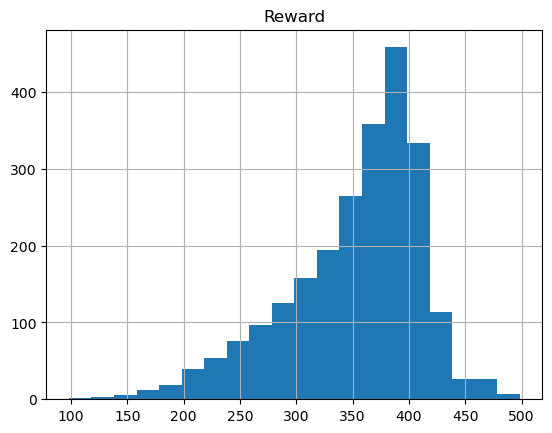

In [8]:
# Distribution of rewards. Since these are unique values we display a histogram.
df.hist(column='Reward', bins=20)

In [9]:
# We introduce a normalised reward to make comparisons easier
df.insert(3, "Normalised reward", (df['Reward'] / df['Reward'].max())**2)

In [10]:
def create_heatmap(variable, df, nbin=25):
    ops = num_of_operators_short_d + num_of_operators_short_b + num_of_operators_long
    best = df.iloc[0,5:]  # scalped_data is sorted by reward so we know the highest reward is located in the first row
    best_x = best[variable]
    best_y = best[variable + ops]
    
    variable = 5 + variable
    x_variable = df.columns[variable]
    y_variable = df.columns[variable + ops]

    m_y, s_y = weighted_avg_and_std(df[y_variable], df['Normalised reward'])
    m_x, s_x = weighted_avg_and_std(df[x_variable], df['Normalised reward'])
    
    title = df.columns[variable][3:]  # put the multiplet name in the title
    
    fig = px.density_heatmap(df, x=x_variable, y=y_variable, z=df['Normalised reward'], nbinsx=nbin, nbinsy=nbin, color_continuous_scale="Reds",title=title)
    fig.add_hrect(y0=(m_y - s_y), y1=(m_y + s_y), line_width=0, fillcolor="purple", opacity=0.2, annotation_text=r"$1 \sigma$")
    fig.add_vrect(x0=(m_x - s_x), x1=(m_x + s_x), line_width=0, fillcolor="purple", opacity=0.2, annotation_text=r"$1 \sigma$")
    fig.add_vline(x=best_x, annotation_text="Max", annotation_position="top right", line_dash="dash")
    fig.add_hline(y=best_y, annotation_text="Max", annotation_position="top right", line_dash="dash")
    fig.update_xaxes(title_text=r'$\text{Scaling dimension } \Delta$')
    fig.update_yaxes(title_text=r'$\text{OPE-squared coefficient } \lambda^2$')
    fig.show()

In [11]:
# fig = px.scatter(df, y='Normalised reward', x='Δ: L[0,0], l=0', color='λ²: L[0,0], l=0')
# fig.show()

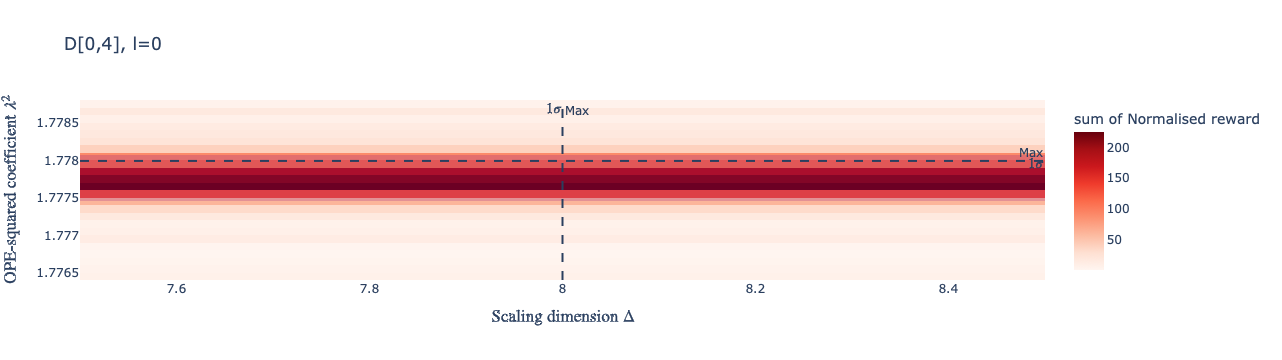

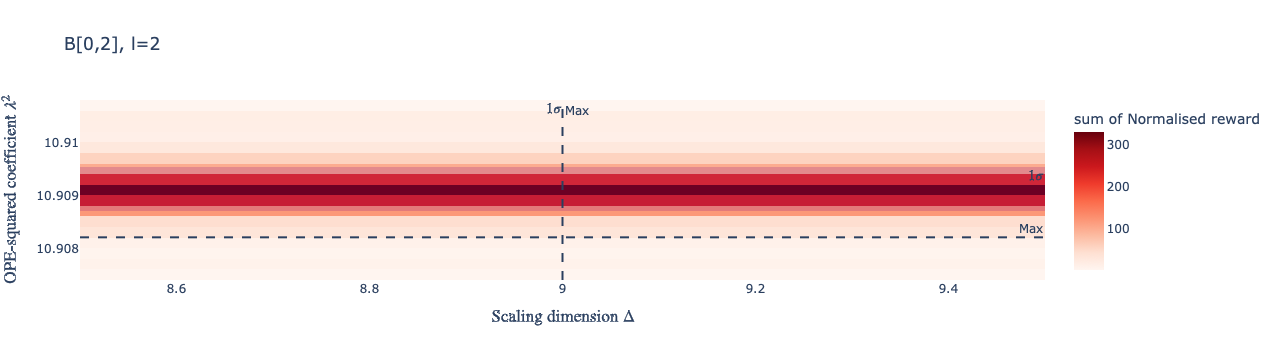

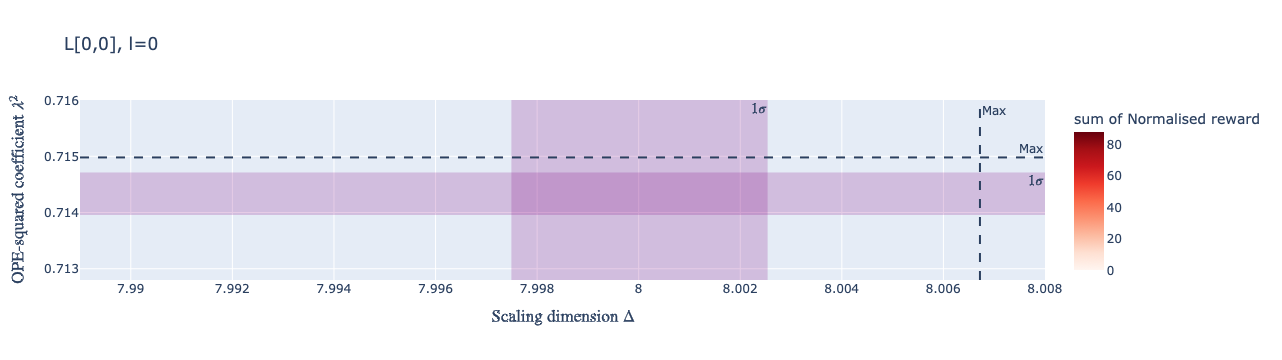

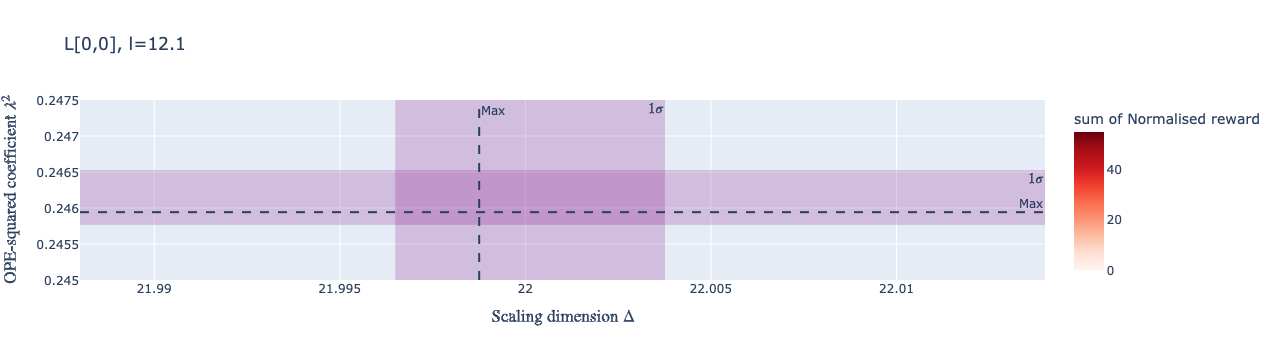

In [12]:
# Look at the heatmaps for select operators
ops = [0, 1, 10, 44]

for op in ops:
    create_heatmap(op, df)

# Plotting for collection of run files

Here we create some charts which compare the 'best' results for different values of the central charge

In [13]:
def create_plot(df, y_data_col_name):
    if y_data_col_name[0] == '\u0394':  # \u0394 is unicode for \Delta
        title_text = r'$\text{Scaling dimension } \Delta$'
        title = y_data_col_name[3:]
    else:
        title_text = r'$\text{OPE-squared coefficient } \lambda^2$'
        title = y_data_col_name[4:]

    x_data = df['Central charge'] ** (-1/3)
    y_data = df[y_data_col_name]
    error_y = df_stdev[y_data_col_name]
    fig = px.line(df, x=x_data, y=y_data, markers=True, text='Central charge', title=title, error_y=error_y)
    fig.update_xaxes(title_text=r'$c^{-1/3}$', range=[0, 0.35])
    fig.update_yaxes(title_text=title_text)
    fig.show()

def create_mixed_plot(df, dfb, y_data_col_name):
    if y_data_col_name[0] == '\u0394':  # \u0394 is unicode for \Delta
        title_text = r'$\text{Scaling dimension } \Delta$'
        title = y_data_col_name[3:]
    else:
        title_text = r'$\text{OPE-squared coefficient } \lambda^2$'
        title = y_data_col_name[4:]

    x_data = df['Central charge'] ** (-1/3)
    y_data_a = df[y_data_col_name]
    y_data_b = dfb[y_data_col_name]
    error_y = df_stdev[y_data_col_name]

    fig = px.scatter(df, x=x_data, y=y_data_a, text='Central charge', title=title, error_y=error_y,
                     trendline="lowess", trendline_options=dict(frac=0.35), trendline_color_override="black")
    fig.add_trace(go.Scatter(x=x_data, y=y_data_a,
                             mode='markers',
                             name='statistical mean'))
    fig.add_trace(go.Scatter(x=x_data, y=y_data_b,
                             mode='markers',
                             name='best reward'))
    fig.update_xaxes(title_text=r'$c^{-1/3}$', range=[0, 0.35])
    fig.update_yaxes(title_text=title_text)
    fig.update_layout({'paper_bgcolor': 'rgba(0,0,0,0)',
                       'plot_bgcolor': 'rgba(0,0,0,0)'})
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', mirror=True)
    fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
    fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
    fig.show()

### Loop through results files and aggregate data

In [14]:
# change directory to the user defined folder
os.chdir(FOLDER)
# get all the filenames in the folder which start with the user defined FILENAME_PREFIX
filenames = glob.glob(FILENAME_PREFIX + '*')
i = 0
# start with an empty list of central charges
list_of_ccs = []

# loop through all the matching files
for filename in filenames:
    # work out the value which appears after c in the filename and put append it to the list of central charges
    str_central_charge = Path(filename).stem.removeprefix(FILENAME_PREFIX)
    # read the csv file into a pandas dataframe
    df = pd.read_csv(filename)
    # get the highest reward
    highest_reward = df['Reward'].max()
    # insert a new column with normalised rewards
    df.insert(3, 'Normalised reward', (df['Reward'] / highest_reward) ** 2)
    # get the solution corresponding to the highest reward
    highest_reward_solution = df.iloc[df['Reward'].idxmax(), 5:].to_numpy()
    # get the global_best
    global_best = get_global_best(df, df.columns[5:])
    # get the weighted standard deviations
    stdev = get_window_sizes(df, df.columns[5:])
    # override the standard deviation of fixed short multiplet weights to be exactly zero
    stdev[0:num_of_operators_short_d + num_of_operators_short_b] = 0

    if str_central_charge == 'SUGRA':
        list_of_ccs.append(np.inf)
    else:
        list_of_ccs.append(int(str_central_charge))
    # now combine the numpy arrays
    if i == 0:
        highest_reward_array = highest_reward_solution
        global_best_array = global_best
        stdev_array = stdev
    else:
        highest_reward_array = np.vstack((highest_reward_array, highest_reward_solution))
        global_best_array = np.vstack((global_best_array, global_best))
        stdev_array = np.vstack((stdev_array, stdev))
    i += 1

# create Pandas dataframes
df_hr = pd.DataFrame(highest_reward_array, columns=df.columns[5:])
df_gb = pd.DataFrame(global_best_array, columns=df.columns[5:])
df_stdev = pd.DataFrame(stdev_array, columns=df.columns[5:])
# insert a column with the central charges
df_hr.insert(0, 'Central charge', np.array(list_of_ccs))
df_gb.insert(0, 'Central charge', np.array(list_of_ccs))
df_stdev.insert(0, 'Central charge', np.array(list_of_ccs))
# sort the dataframes in descending order of central charge
df_hr = df_hr.sort_values(by='Central charge', ascending=False)
df_gb = df_gb.sort_values(by='Central charge', ascending=False)
df_stdev = df_stdev.sort_values(by='Central charge', ascending=False)

### Define which multiplets to plot and the plot type

In [15]:
# the entries in mult should match the DataFrame column names
mult = ['Δ: L[0,0], l=0', 'Δ: L[0,0], l=0.1', 'Δ: L[0,0], l=8',
        'λ²: D[0,4], l=0', 'λ²: B[0,2], l=2', 
        'λ²: L[0,0], l=6', 'λ²: L[0,0], l=6.1',
        'λ²: L[0,0], l=8']

# mult = df_hr.columns[1:].tolist()

plot_type = 'mixed'  # select one of 'global_best', 'highest_reward' or 'mixed'

### Generate the plots

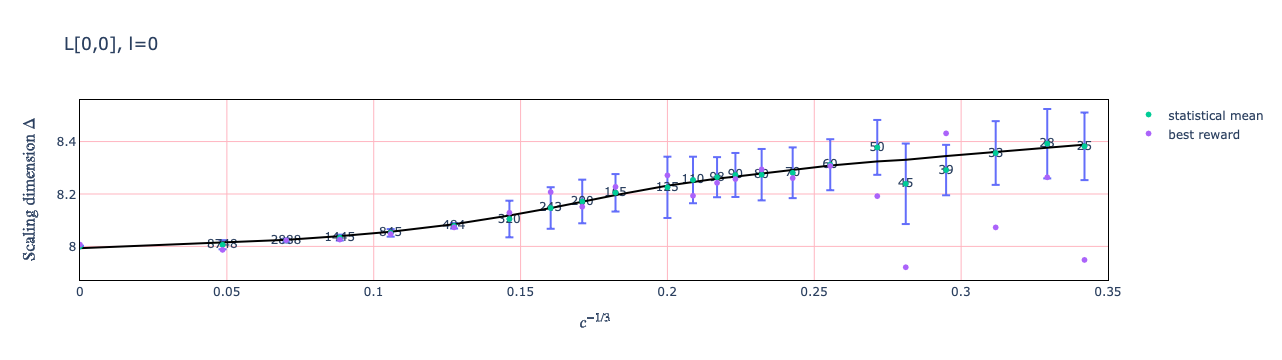

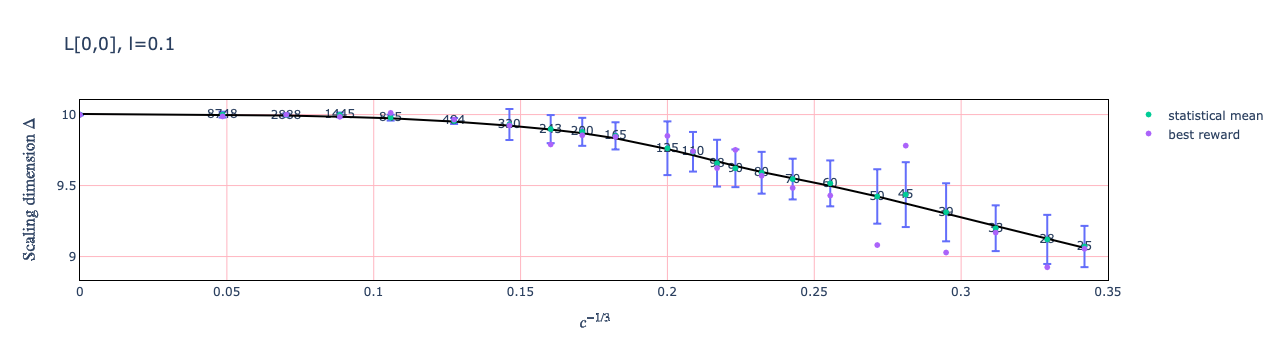

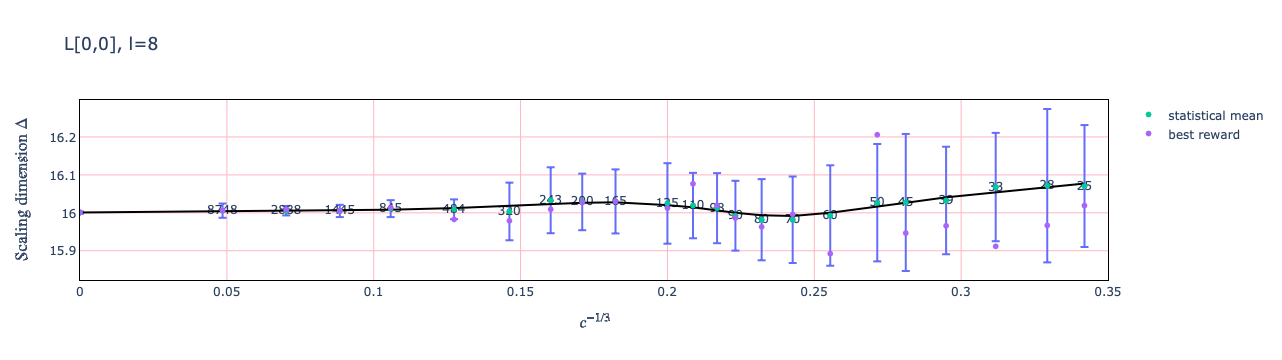

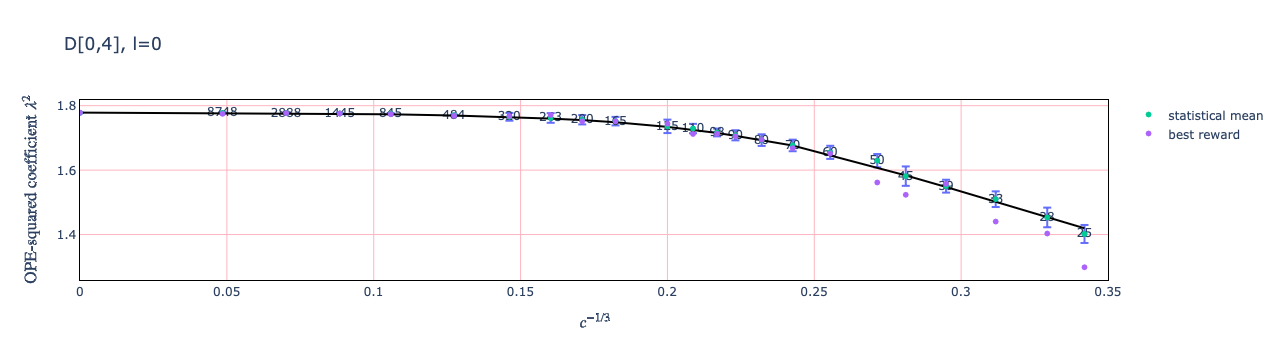

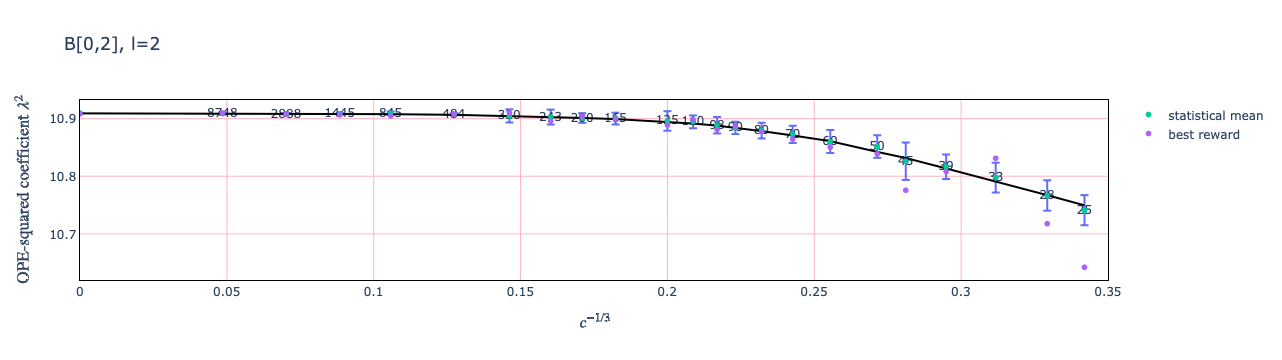

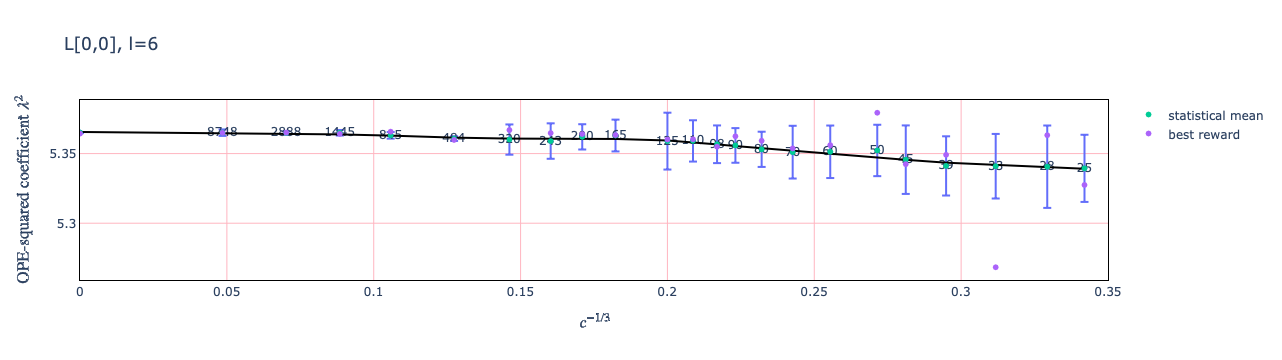

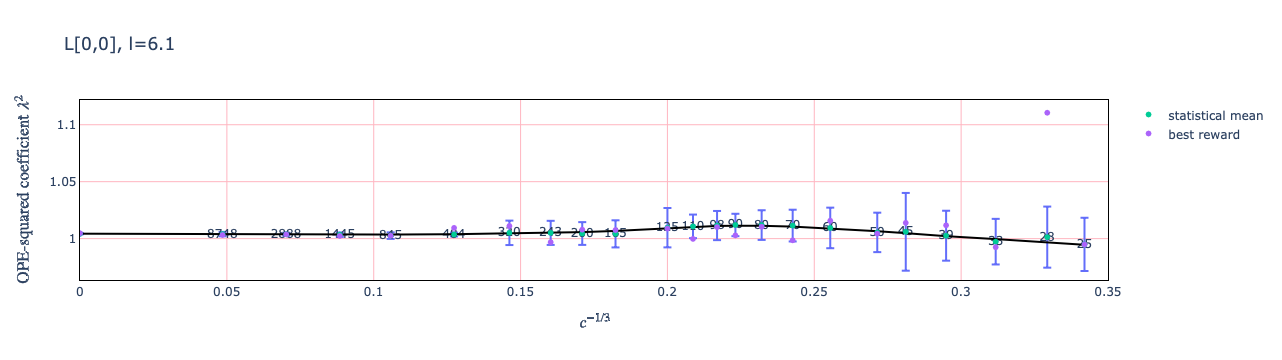

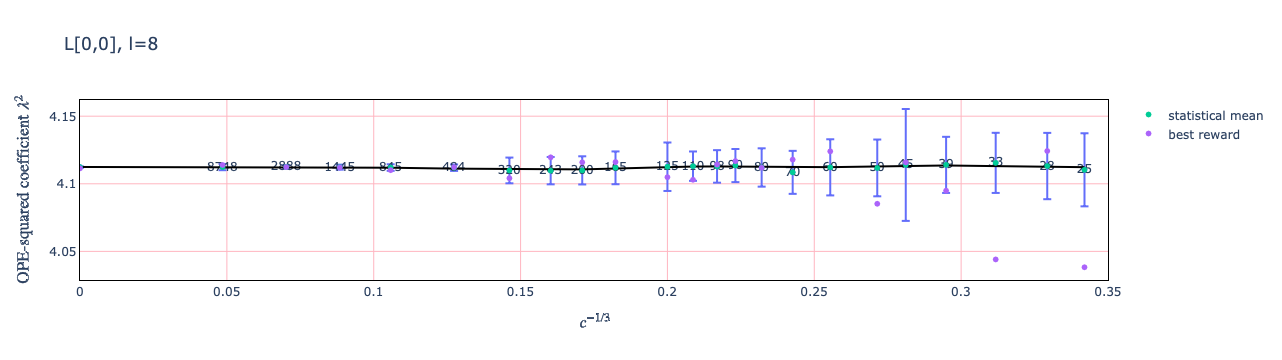

In [16]:
for m in mult:
    if plot_type == 'global_best':
        create_plot(df_gb, m)
    elif plot_type == 'highest_reward':
        create_plot(df_hr, m)
    elif plot_type == 'mixed':
        create_mixed_plot(df_gb, df_hr, m)